#### Project wavs into UMAP and cluster using HDBSCAN
- for each individual, for each WAV, grab syllables as spectrograms of equal length
- project spectrograms into UMAP
- cluster UMAP projections

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [69]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [4]:
from avgn.signalprocessing.create_spectrogram_dataset import create_syllable_df

In [5]:
from avgn.visualization.projections import scatter_projections
from avgn.visualization.quickplots import draw_projection_plots

### Collect data

In [6]:
hparams = HParams(
    num_mel_bins = 32
    )

In [7]:
DATASET_ID = 'koumura_bengalese_finch'
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

In [24]:
# transcription types
dataset.sample_json['indvs'][list(dataset.sample_json['indvs'].keys())[0]].keys()

odict_keys(['notes'])

#### cluster and plot

In [9]:
nex = -1 # for quick viz, how many data points to fit

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


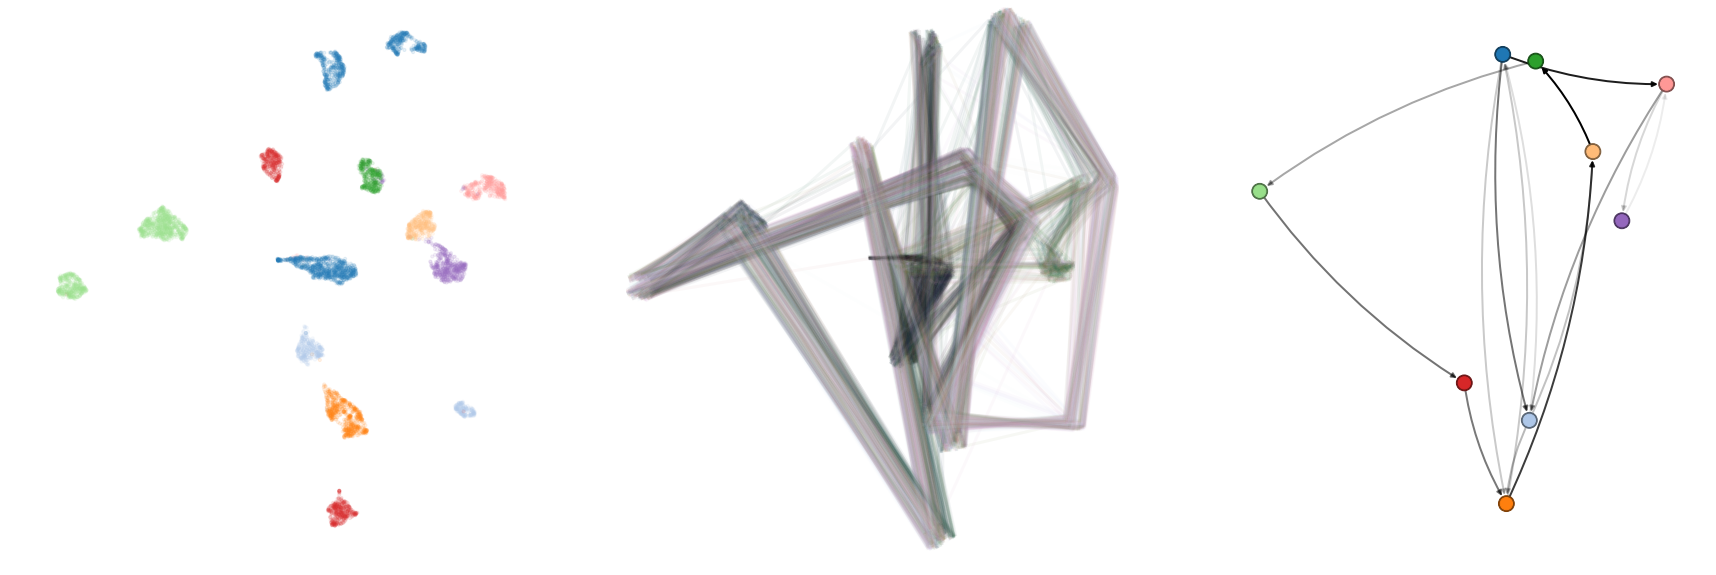

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


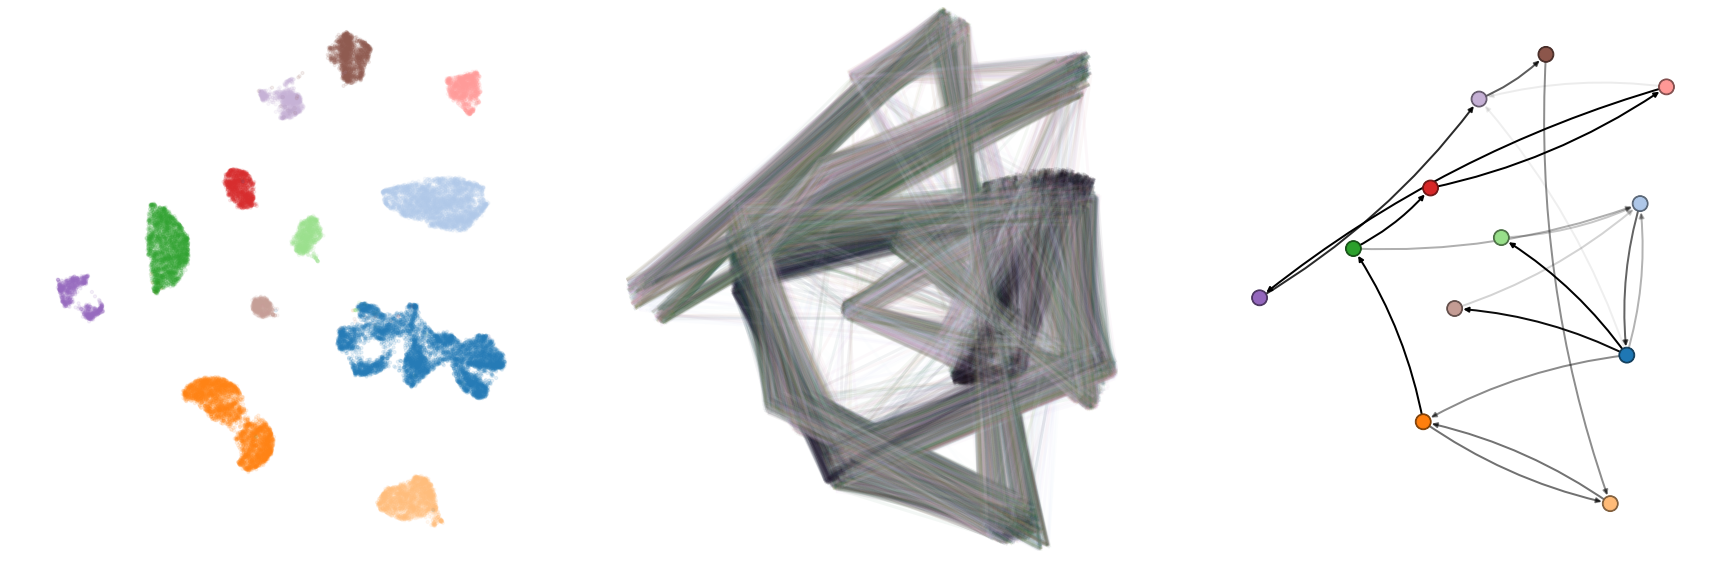

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 7 separate connected components using meta-embedding (experimental)
  n_components


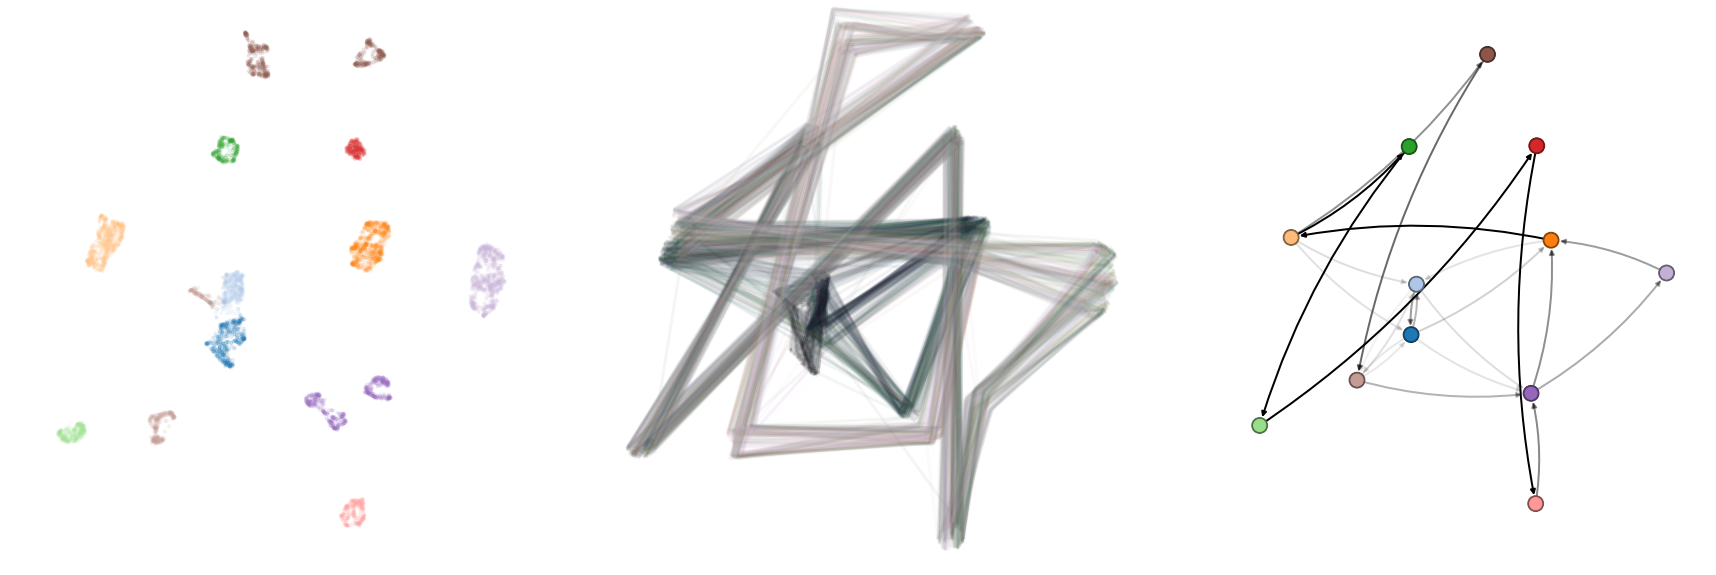

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 12 separate connected components using meta-embedding (experimental)
  n_components


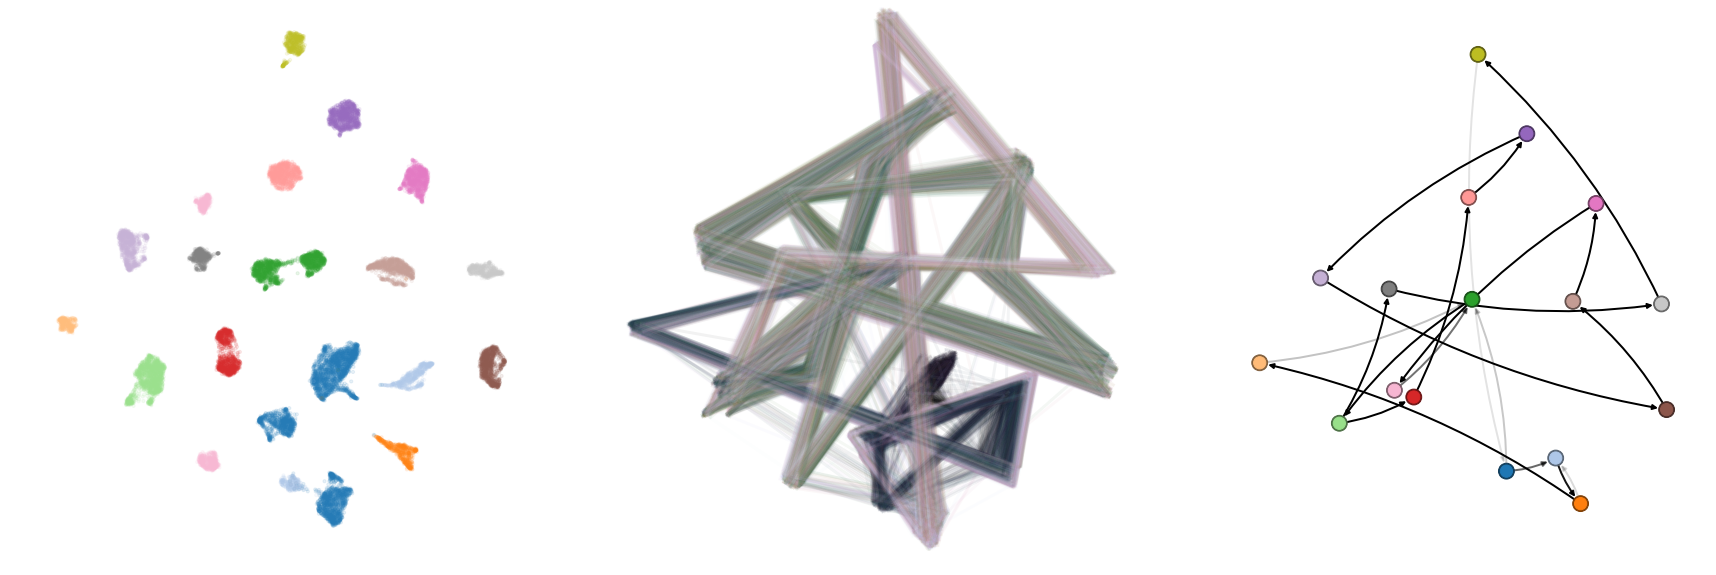

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


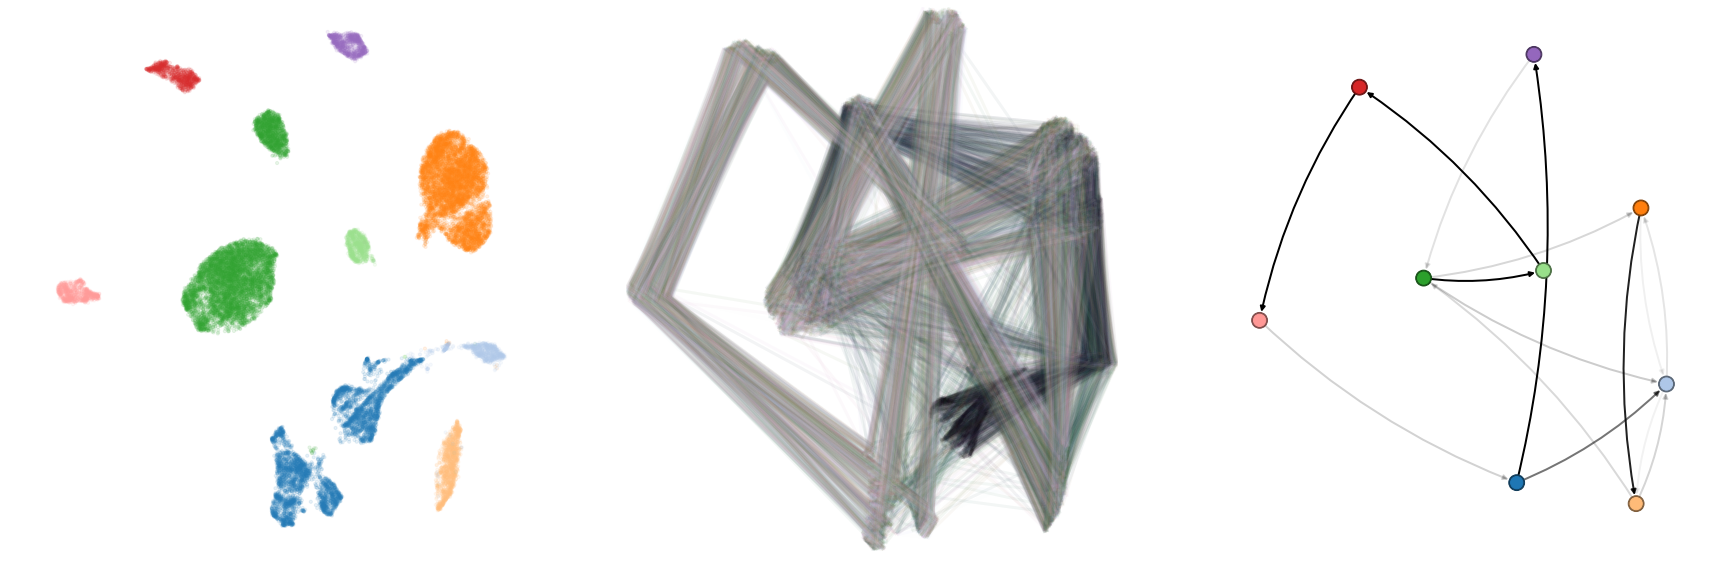

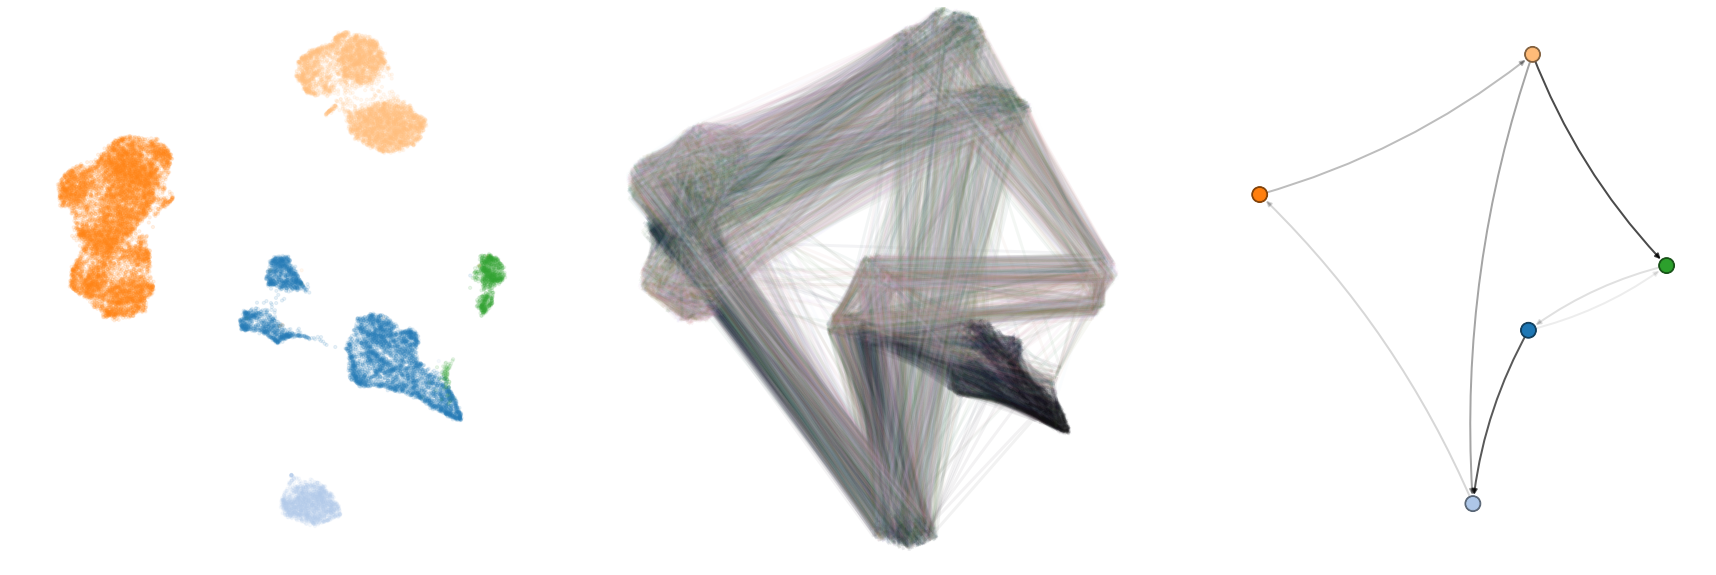

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components


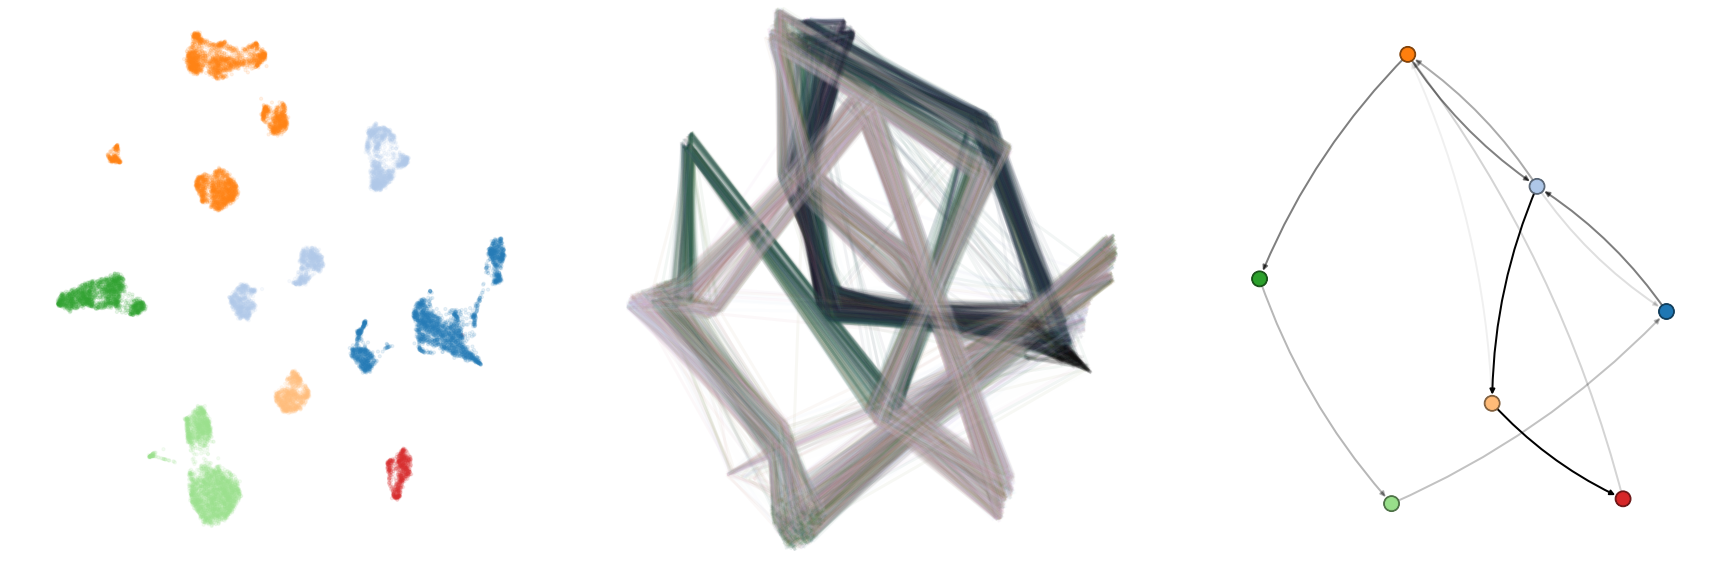

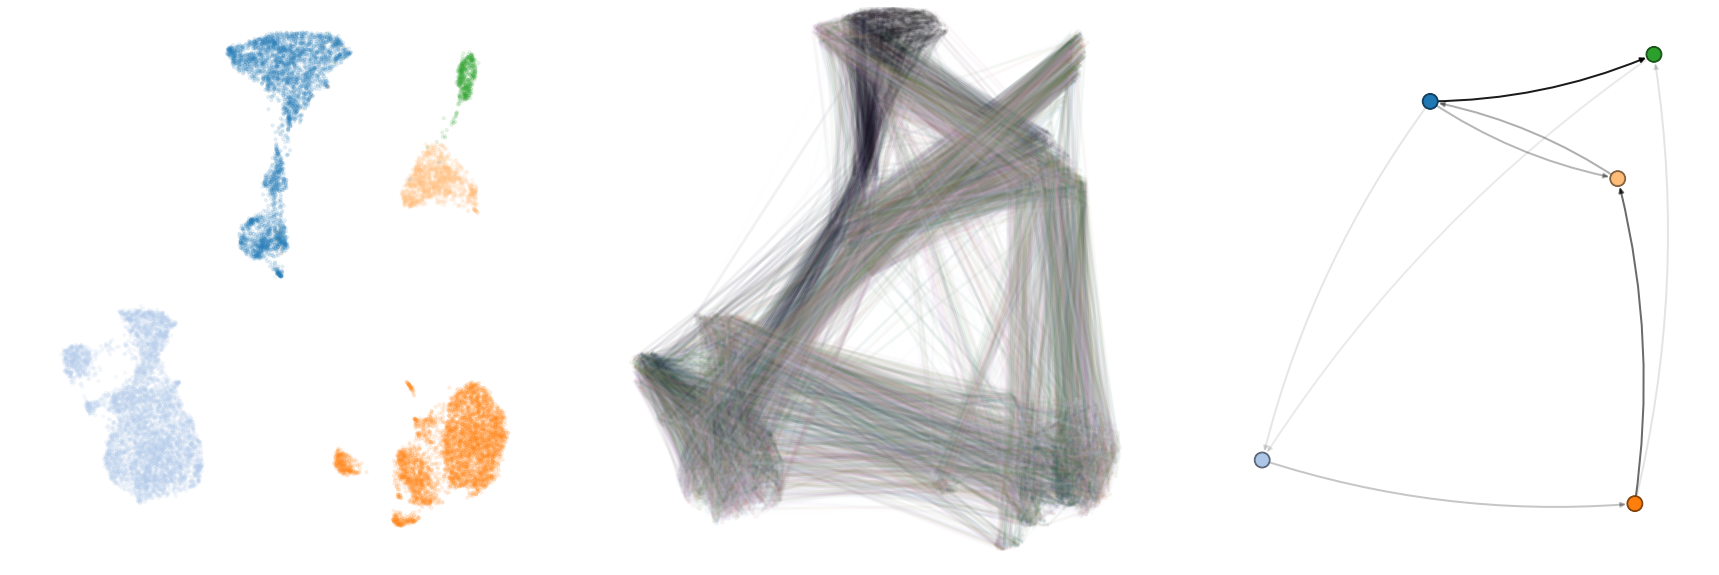

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


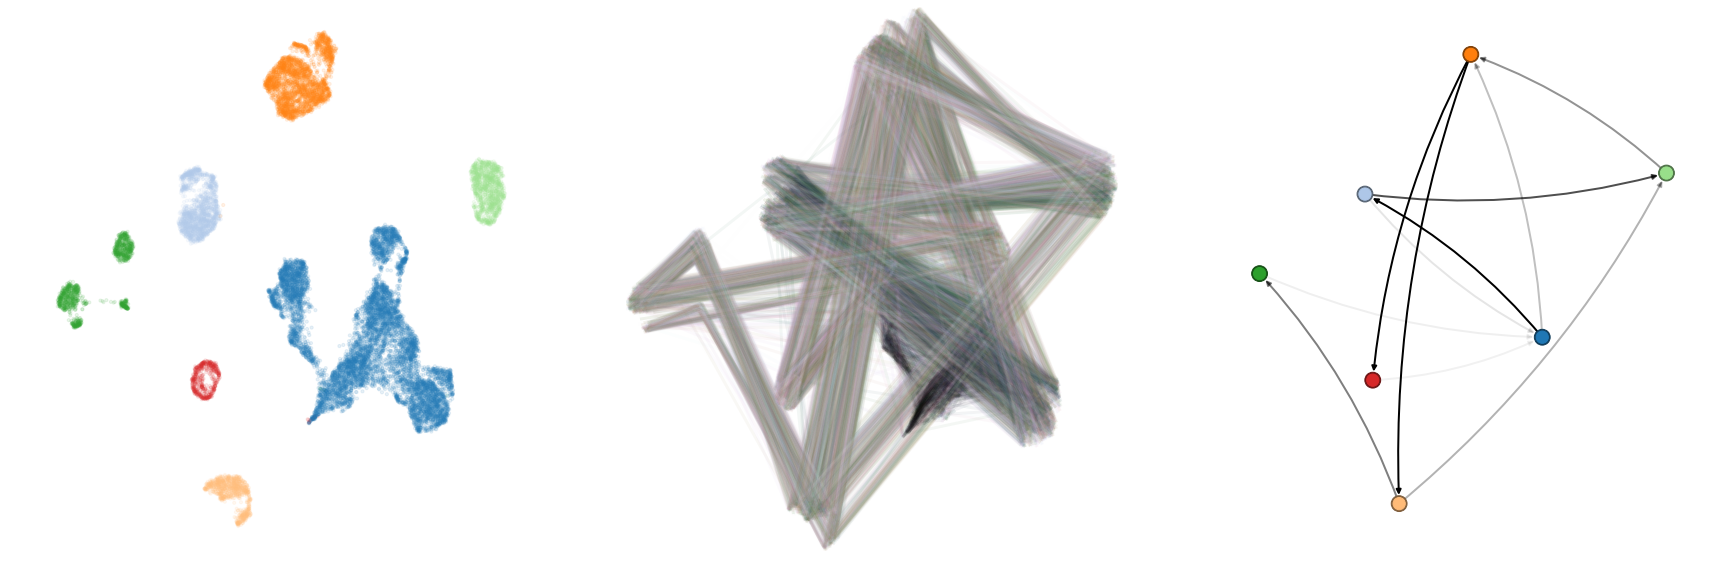

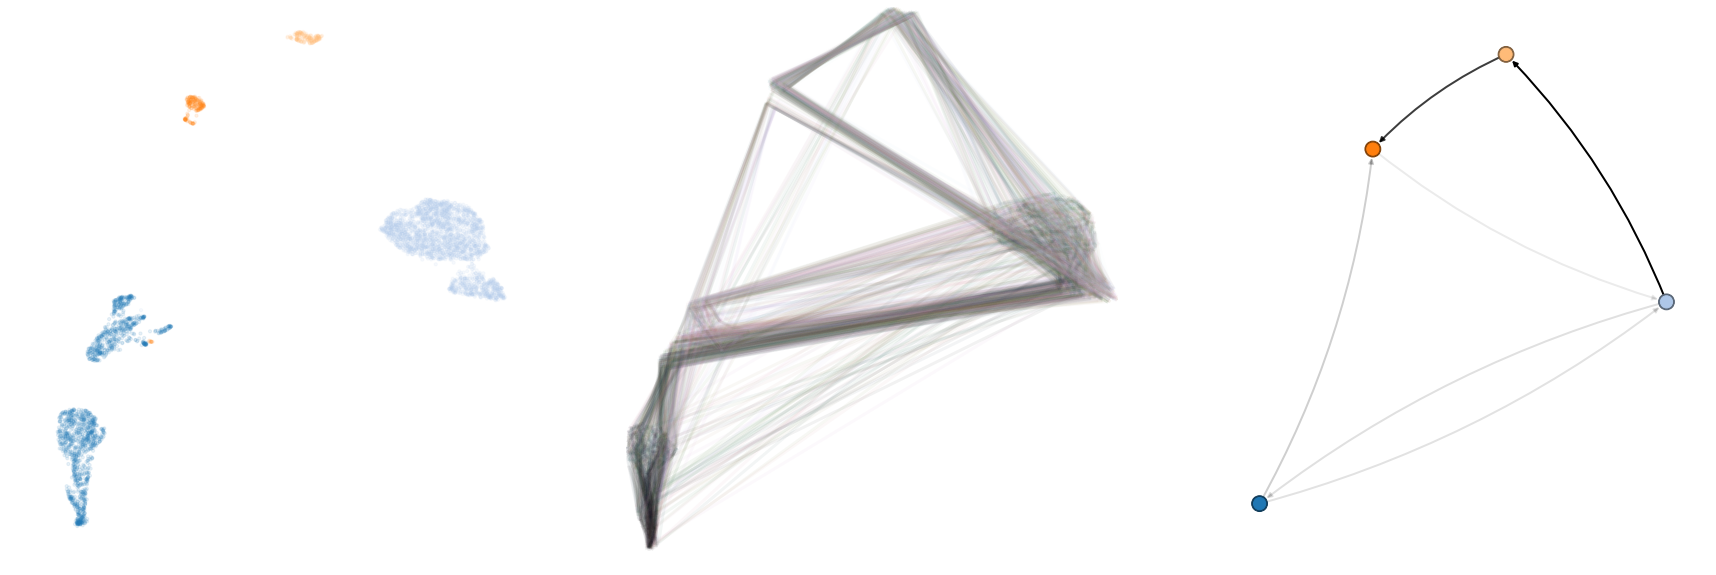

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components


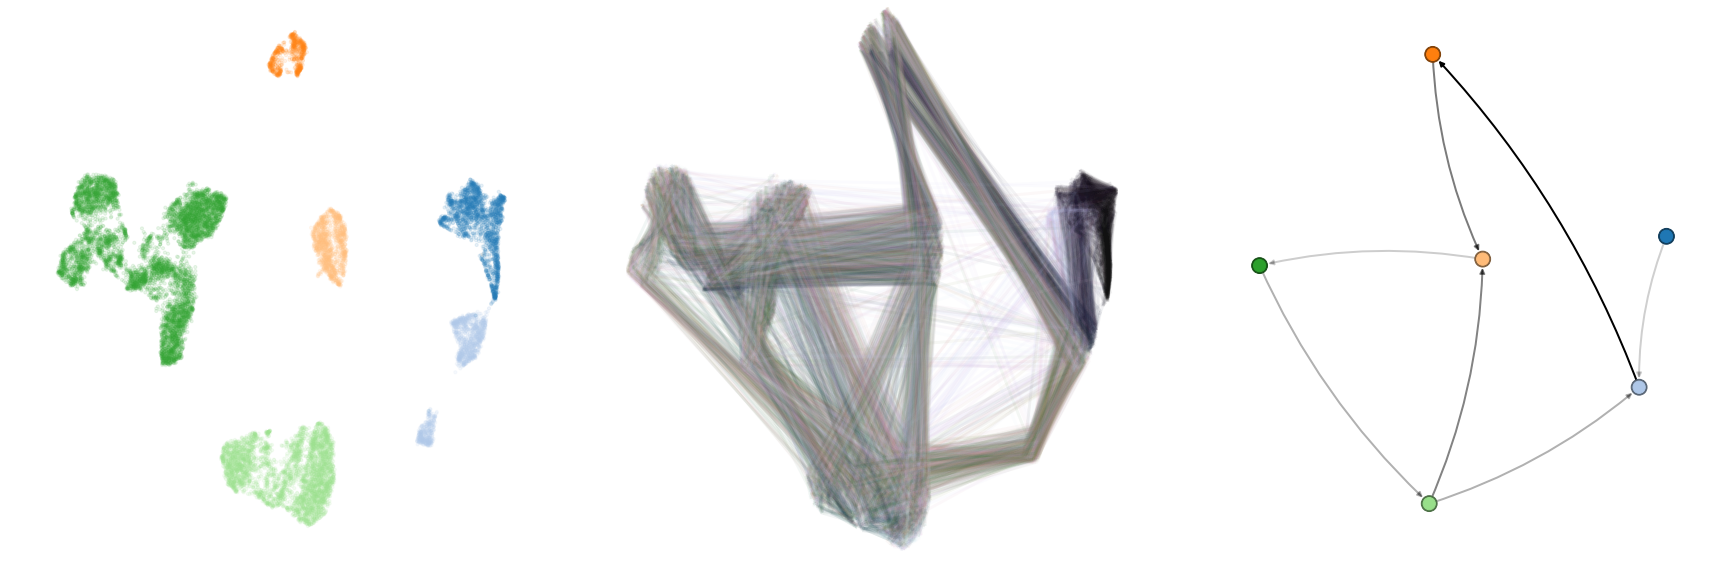

In [64]:
syllable_dfs = {}
for indv in tqdm(dataset._unique_indvs, desc="indvs"):
    print(indv)
    # create dataframe
    syllable_dfs[indv] = create_syllable_df(dataset, indv, unit="notes", log_scaling_factor=8)[:nex]
    specs_flattened = flatten_spectrograms(
        np.array(list(syllable_dfs[indv].syllables_spec.values))
    )

    fit = umap.UMAP(min_dist=0.25)
    syllable_dfs[indv]["umap"] = list(fit.fit_transform(specs_flattened))

    # plot data
    draw_projection_plots(syllable_dfs[indv])
    plt.show()

In [67]:
syllable_dfs['Bird1'][:3]

syllables_sequence_id  syllables_sequence_pos  \
0                      0                       0   
1                      0                       1   
2                      0                       2   

                                       syllables_wav  syllables_rate  \
0  [0.00010429580874564355, -3.685241476730734e-0...           32000   
1  [-0.00025558206636041615, -0.00014670878654945...           32000   
2  [0.00013577303249693684, 0.0003174299934470633...           32000   

  syllables_labels                                     syllables_spec  \
0                0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1                0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2                0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                      umap  
0  [10.845855, -2.2115288]  
1  [8.8575945, -2.3941612]  
2    [8.885393, -4.024104]

### save dataframes

In [68]:
syllable_dfs.keys()

dict_keys(['Bird0', 'Bird1', 'Bird10', 'Bird2', 'Bird3', 'Bird4', 'Bird5', 'Bird6', 'Bird7', 'Bird8', 'Bird9'])

In [100]:
for indv in tqdm(syllable_dfs.keys()):
    save_loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / (indv + '.pickle')
    ensure_dir(save_loc)
    syllable_dfs[indv].to_pickle(save_loc)